In [1]:
# -*- coding:utf-8 -*-

import matplotlib.pyplot as plt
import networkx as nx
from Cookbook import oauth_login, get_friends_followers_ids, get_user_profile, make_twitter_request
from builtins import sorted, reversed
import twitter
import threading
import time
import inspect
import ctypes
import string
import csv

In [2]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/jojo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/jojo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jojo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
def _async_raise(tid, exctype):
    """raises the exception, performs cleanup if needed"""
    tid = ctypes.c_long(tid)
    if not inspect.isclass(exctype):
        exctype = type(exctype)
    res = ctypes.pythonapi.PyThreadState_SetAsyncExc(tid, ctypes.py_object(exctype))
    if res == 0:
        raise ValueError("invalid thread id")
    elif res != 1:
        ctypes.pythonapi.PyThreadState_SetAsyncExc(tid, None)
        raise SystemError("PyThreadState_SetAsyncExc failed")

def stop_thread(thread):
    _async_raise(thread.ident, SystemExit)

In [4]:
def Get_Tweets(keyword, geoCode):
    twitter_api = oauth_login()
    
    ## Search Tweets by Keyword(s)
    twitter_stream = twitter.TwitterStream(auth=twitter_api.auth)
    stream = twitter_stream.statuses.filter(track=keyword, locations=geoCode, language='en')
    
    i = 0
    
    for tweet in stream:
        if ('text' not in tweet): continue
        if 'TT' not in tweet['text'] and 'RT' not in tweet['text']:
            # remove links from the tweets 
            text = re.sub(r"(?:\@|https?\://)\S+", "", tweet['text']) 
            result.append(Remove_Emoji(text))
            
            if(i % 50 == 0): print(i)
            i = i + 1
           

In [5]:
import emoji

def Remove_Emoji(text):
    allchars = [str for str in text]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return clean_text

In [6]:
def Stem_Lemm():
    
    ## tokenize
    for tweet in result:
        token_t = word_tokenize(tweet)
        tokenized.append(token_t)
  
    ## stem & remove stopworda
    stop = stopwords.words('english')
    for token in tokenized:
        wnl = WordNetLemmatizer()
        stems = [wnl.lemmatize(t) for t in token]
        tokens_filtered = [w for w in stems if w.lower() not in stop and w.lower() not in string.punctuation]
        tokenized[tokenized.index(token)] = tokens_filtered


In [7]:
def Save_To_Csv(filename):
    
    with open(filename,'w') as f:
        writer=csv.writer(f)
       
        for t in tokenized:
            data=','.join(t)
            writer.writerow([data])

In [8]:
def Tweet_Crawler(keyword, geoCode, tweetNum, csvFile):
    # start threading
    t = threading.Thread(target=Get_Tweets, args=(keyword, geoCode))
    
    t.start()
    print("Thread Start")
    
    ## waiting for data collection
    while len(result) < tweetNum:
        pass
    
    ## kill thread
    stop_thread(t)
    print("Thread End")
    
    ## normalize noise
    Stem_Lemm()
    
    ## save to csv
    Save_To_Csv(csvFile)

In [9]:
import sys,tweepy,csv,re
from textblob import TextBlob
import matplotlib.pyplot as plt

In [10]:
class SentimentAnalysis:
    
    def __init__(self, keyword, geoCode, tweetNum, csvFile):
        self.keyword = keyword
        self.geoCode = geoCode
        self.tweetNum = tweetNum
        self.csvFile = csvFile
        
    def Get_Polarity(self, p):
        if (p == 0): return "Neutral"
        elif (0.0 < p <= 0.3): return "Weak Positive"
        elif (0.3 < p <= 0.6): return "Positive"
        elif (0.6 < p <= 1.0): return "Strong Positive"
        elif (-0.3 < p <= 0): return "Weak Negative"
        elif (-0.6 < p <= -0.3): return "Negative"
        elif (-1.0 <= p <= -0.6): return "Strong Negative"
                    
    def Analysis(self):
     # creating some variables to store info
        polarity, total_polarity = 0, 0
        dic = {"Strong Positive": 0, "Positive": 0, "Weak Positive": 0, "Neutral": 0, \
               "Weak Negative": 0, "Negative": 0, "Strong Negative": 0}
        
        new_line = []
        
        # read in the collected tweets in csv file
        with open(self.csvFile) as csv_file:
            content = csv_file.read() 
            i = 0

        for tweet in (content).split('\n'):
            # skip the last line (empty space due to the split function)
            if(i >= self.tweetNum): break 

            new_line = ' '.join(tweet.split(','))

            # use TextBlob to calculate polarity of current tweet
            analysis = TextBlob(new_line)
            polarity = analysis.sentiment.polarity

            # add the total polarity to get the general opinion
            total_polarity += polarity
            current = self.Get_Polarity(polarity)
            if(current not in dic): print(current, polarity)
            dic[current] += 1

            i += 1
            
        # calculate an overall opinion among all these tweets by taking average
        general = total_polarity / float(self.tweetNum)     
        print("\n1. General Idea =>", self.Get_Polarity(general))

        # calculate the percentage of each opinion
        for num in dic:
            dic[num] = 100 * dic[num] / float(self.tweetNum) 

        # print out a more detailed report
        print("\n2. Detailed Report: \n")

        print("{:>9,.2f}% people thought it's Positive.".format(dic["Positive"]))
        print("{:>9,.2f}% people thought it's Weakly Positive.".format(dic["Weak Positive"]))
        print("{:>9,.2f}% people thought it's Strongly Positive.\n".format(dic["Strong Positive"]))
        
        print("{:>9,.2f}% people thought it's Negative.".format(dic["Negative"]))
        print("{:>9,.2f}% people thought it's Weakly Negative.".format(dic["Weak Negative"]))
        print("{:>9,.2f}% people thought it's Strongly Negative.\n".format(dic["Strong Negative"]))
        
        print("{:>9,.2f}% people thought it's Neutral.\n".format(dic["Neutral"]))
        
        # write result to output file
        
        ''' 
        header = "Keyword(s)", "Geocode", "Number of Tweets",
                 "Positive", "Weak Positive", "Strong Positive",
                 "Negative", "Weak Negative", "Strong Negative", "Neutral"
        '''
            
        with open('results.csv', 'a', newline='') as csvfile:
            writer = csv.writer(csvfile, delimiter='\t')
            
            writer.writerow([self.keyword]+[self.geoCode]+[self.tweetNum]+[dic["Positive"]]+[dic["Weak Positive"]]+\
                           [dic["Strong Positive"]]+[dic["Negative"]]+[dic["Weak Negative"]]+[dic["Strong Negative"]]+\
                           [dic["Neutral"]])
            csvfile.close()
            
        self.Draw_Pie_Chart(dic)
        
    def Draw_Pie_Chart(self, dic):
        if not dic: return
        labels = ['Positive [' + str(dic["Positive"]) + '%]', 'Weakly Positive [' + str(dic["Weak Positive"]) + '%]',\
                  'Strongly Positive [' + str(dic["Strong Positive"]) + '%]', 'Neutral [' + str(dic["Neutral"]) + '%]',\
                  'Negative [' + str(dic["Negative"]) + '%]', 'Weakly Negative [' + str(dic["Weak Negative"]) + '%]', \
                  'Strongly Negative [' +  str(dic["Strong Negative"]) + '%]']
        
        # define the value and coloe of each pie 
        pies = dic.values()
        colors = ['darkgreen','yellowgreen','lightgreen', 'gold', 'lightsalmon','red','darkred']
        patches, texts = plt.pie(pies, colors=colors, startangle=90)
        
        plt.legend(patches, labels, loc="best")
        plt.title('Sentiment Analysis on ' + '"' + self.keyword + '"' + ' with ' + str(self.tweetNum) + ' Tweets')
        
        plt.axis('equal')
        plt.tight_layout()
        
        plt.show()


Thread Start
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
Thread End
Evaluation on "Microsoft" based on 1000 tweets:

1. General Idea => Weak Positive

2. Detailed Report: 

    13.20% people thought it's Positive.
    19.20% people thought it's Weakly Positive.
     6.80% people thought it's Strongly Positive.

     4.80% people thought it's Negative.
     7.20% people thought it's Weakly Negative.
     1.80% people thought it's Strongly Negative.

    47.00% people thought it's Neutral.



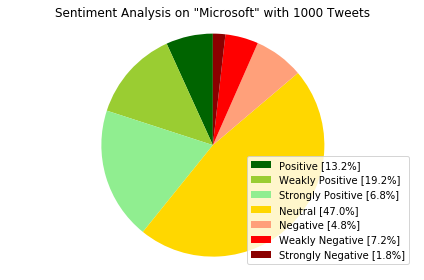

In [12]:
if __name__ == '__main__':
    
    global result
    result = []
    
    global tokenized
    tokenized = []
    
    # number of tweet to retrive
    tweetNum = 1000
    
    # file to store tweets
    csvFile = 'test1.csv'
    
    # define keyword(s) to search on
    keyword = 'Microsoft'
    
    # define location with 4 values (bound box)
    geoCode =  '-74.2589, 40.4774, -73.7004, 40.9176,-78.9125, 42.8260, -78.7952, 42.9664,-76.2045, 42.9844, -76.0741, 43.0861'
           #'-118.6682, 33.7037, -118.1552, 34.3368,-122.75,36.8,-121.75,37.8,-122.0047, 37.3231, -121.9298, 37.4190,-122.2027, 37.2888, -122.0891, 37.4658'
          
    Tweet_Crawler(keyword, geoCode, tweetNum, csvFile)
    
    print("Evaluation on " + '"' + keyword + '"' + " based on " + str(tweetNum) + " tweets:")
    
    # sentiment analysis
    sa = SentimentAnalysis(keyword, geoCode, tweetNum, csvFile)
    sa.Analysis()
    